In [1]:
# Comparing Func Shaefer with and without "extra labels"

In [29]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from sklearn.cluster import SpectralClustering
import sklearn
from nilearn import plotting
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels

In [4]:
# get the current notebook path
note_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/notebook/"
data_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/data/"

In [5]:
# load npz data
data = load(data_path + 'correlation_matrix_Schaefer_group.npz')
correlation = data['corr_group']
indices = data['indices']

In [6]:
# Average correlation matrix with extra labels
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [8]:
# remove the subcortical regions average corr matrix
corr_avgFC = corr_avg[:,:-19]

In [7]:
# Reshape and concatenate subjects of corr matrxi with extra labels
corr = np.moveaxis(correlation,0,2)
corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corr_concat[np.isnan(corr_concat)] = 1

In [9]:
corr.shape

(599, 419, 173)

In [15]:
# remove the subcortical regions
corr_FC = corr[:,:-19,:]
corr_FC.shape

(599, 400, 173)

In [16]:
# Reshape and concatenate subjects of corr matrxi without extra labels
corrFC_concat = corr_FC.reshape([corr_FC.shape[0],corr_FC.shape[1]*corr_FC.shape[2]])
corrFC_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corrFC_concat[np.isnan(corrFC_concat)] = 1

In [14]:
corrFC_concat.shape

(599, 69200)

In [17]:
# Spectral Clustering with extra labels
# Function to save niftis
def save_label_nii (labelimg,affine,header,out_nifti):
    img = nib.Nifti1Image(labelimg,affine=affine,header=header)
    nib.save(img,out_nifti)

# get seed data
afile = (data_path + 'seed-BASF_Schaefer_BigBrain1p6mm_59k.nii.gz')
atlas = nib.load(afile)
atlas_data = atlas.get_fdata()
    
# Output
max_k = 4
cluster_range = range(2,max_k+1)
cluster = list(cluster_range)
out_nii_list =[f'Func_Schaefer+_method-spectralcosine_k-'+ cluster +'_cluslabels.nii.gz' for cluster in[str(int) for int in cluster]]
labels = np.zeros((corr_concat.shape[0],len(cluster_range)))

# Run spectral clustering and save results to nifti
for i,k in enumerate(cluster_range):
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_concat)
    labels[:,i] = clustering.labels_
    
    labelimg = np.zeros(atlas_data.shape)
    for j in range(0,len(atlas_data[atlas_data==16])):
        labelimg[indices[j][0],indices[j][1],indices[j][2]] = labels[j,i]+1
    
    print(f'i={i},k={k},saving {out_nii_list[i]}')
    save_label_nii(labelimg,atlas.affine,atlas.header,out_nii_list[i])

# Save results to CSV file
df = pd.DataFrame(labels,columns=cluster_range)
df.to_csv('Func_Schaefer+_clusterlabels_seed-BASF_1p6mm.csv')

i=0,k=2,saving Func_Schaefer+_method-spectralcosine_k-2_cluslabels.nii.gz
i=1,k=3,saving Func_Schaefer+_method-spectralcosine_k-3_cluslabels.nii.gz
i=2,k=4,saving Func_Schaefer+_method-spectralcosine_k-4_cluslabels.nii.gz


In [23]:
# Spectral Clustering without extra labels
# Function to save niftis
def save_label_nii (labelimg,affine,header,out_nifti):
    img = nib.Nifti1Image(labelimg,affine=affine,header=header)
    nib.save(img,out_nifti)

# get seed data
afile = (data_path + 'seed-BASF_Schaefer_BigBrain1p6mm_59k.nii.gz')
atlas = nib.load(afile)
atlas_data = atlas.get_fdata()
    
# Output
max_k = 4
cluster_range = range(2,max_k+1)
cluster = list(cluster_range)
out_nii_list =[f'Func_Schaefer_only_method-spectralcosine_k-'+ cluster +'_cluslabels.nii.gz' for cluster in[str(int) for int in cluster]]
labels = np.zeros((corrFC_concat.shape[0],len(cluster_range)))

# Run spectral clustering and save results to nifti
for i,k in enumerate(cluster_range):
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corrFC_concat)
    labels[:,i] = clustering.labels_
    
    labelimg = np.zeros(atlas_data.shape)
    for j in range(0,len(atlas_data[atlas_data==16])):
        labelimg[indices[j][0],indices[j][1],indices[j][2]] = labels[j,i]+1
    
    print(f'i={i},k={k},saving {out_nii_list[i]}')
    save_label_nii(labelimg,atlas.affine,atlas.header,out_nii_list[i])

# Save results to CSV file
df = pd.DataFrame(labels,columns=cluster_range)
df.to_csv('Func_Schaefer_only_clusterlabels_seed-BASF_1p6mm.csv')

i=0,k=2,saving Func_Schaefer_only_method-spectralcosine_k-2_cluslabels.nii.gz
i=1,k=3,saving Func_Schaefer_only_method-spectralcosine_k-3_cluslabels.nii.gz
i=2,k=4,saving Func_Schaefer_only_method-spectralcosine_k-4_cluslabels.nii.gz


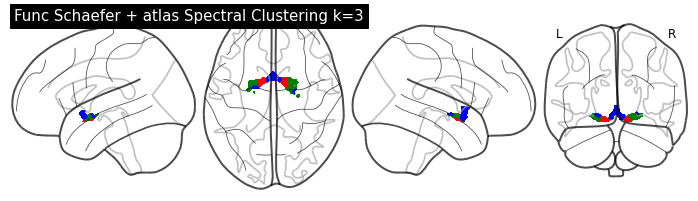

In [20]:
file = ('Func_Schaefer+_method-spectralcosine_k-3_cluslabels.nii.gz')
cluster = nib.load(file)
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green', 'blue'])
display = plotting.plot_glass_brain(None, display_mode='lzry', colorbar=True)
display.add_contours(cluster, filled=True, cmap=colors)
display.title('Func Schaefer + atlas Spectral Clustering k=3')

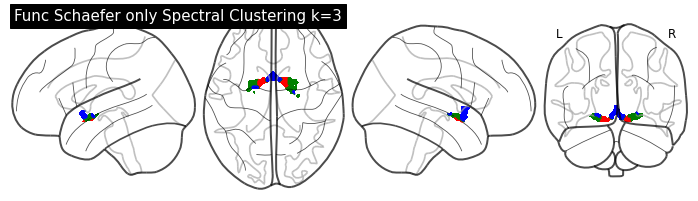

In [24]:
file = ('Func_Schaefer_only_method-spectralcosine_k-3_cluslabels.nii.gz')
cluster = nib.load(file)
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green', 'blue'])
display = plotting.plot_glass_brain(None, display_mode='lzry', colorbar=True)
display.add_contours(cluster, filled=True, cmap=colors)
display.title('Func Schaefer only Spectral Clustering k=3')

In [26]:
# Gradient with Schaefer + atlas average data
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=10, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

# save the BF gradients niftis
# get seed data
seed_file = (data_path + 'seed-BASF_Schaefer_BigBrain1p6mm_59k.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()

for gradi in range(5):

    grad_vol = np.zeros(seed_vol.shape)
    grad_vol[indices[:,0],indices[:,1],indices[:,2]] = gm.gradients_[:,gradi] 

    grad_nib = nib.Nifti1Image(grad_vol,affine=seed.affine,header=seed.header)
    grad_nib.to_filename(f'Func_Schaefer+_gradient_{gradi}.nii.gz')

GradientMaps(kernel='normalized_angle', random_state=0)


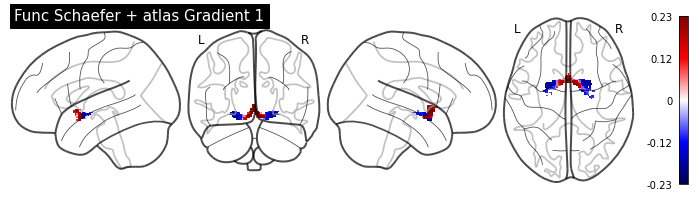

In [30]:
# display figures
gradi = 0
grad_nib = nib.load(f'Func_Schaefer+_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Func Schaefer + atlas Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

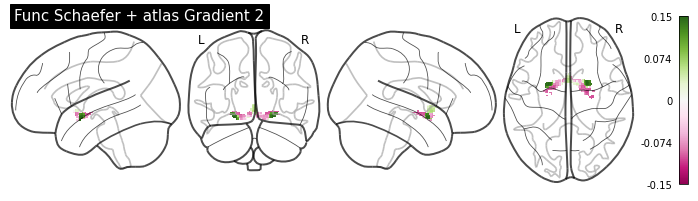

In [31]:
gradi = 1
grad_nib = nib.load(f'Func_Schaefer+_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PiYG')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Func Schaefer + atlas Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

In [27]:
# Gradient with Schaefer only average data
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=10, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avgFC))

# save the BF gradients niftis
# get seed data
seed_file = (data_path + 'seed-BASF_Schaefer_BigBrain1p6mm_59k.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()

for gradi in range(5):

    grad_vol = np.zeros(seed_vol.shape)
    grad_vol[indices[:,0],indices[:,1],indices[:,2]] = gm.gradients_[:,gradi] 

    grad_nib = nib.Nifti1Image(grad_vol,affine=seed.affine,header=seed.header)
    grad_nib.to_filename(f'Func_Schaefer_only_gradient_{gradi}.nii.gz')

GradientMaps(kernel='normalized_angle', random_state=0)


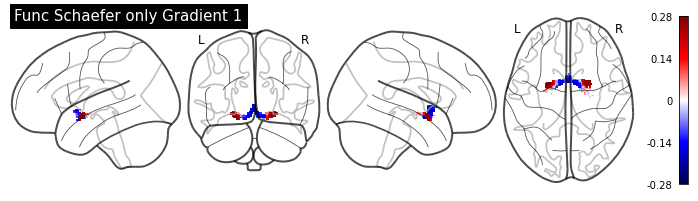

In [32]:
# display figures
gradi = 0
grad_nib = nib.load(f'Func_Schaefer_only_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Func Schaefer only Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

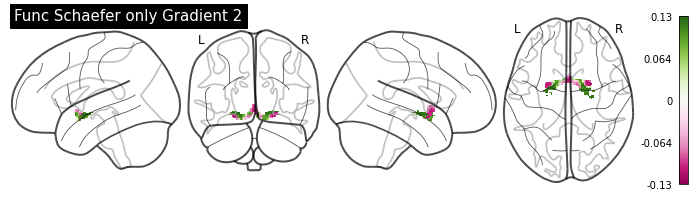

In [33]:
gradi = 1
grad_nib = nib.load(f'Func_Schaefer_only_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PiYG')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Func Schaefer only Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)